<a href="https://colab.research.google.com/gist/fool321/e44d8dc6b743a58b4ce7ad9c1773da25/re_fi_wtffpad_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Re_Fi_WTFFPAD
This notebook divided into 3 part:
1. Data Load
2. Model Build
3. Model Evaluation



## Data Load 
Load data from WTF-PAD dataset

### mount data

In [1]:
# mount data
from google.colab import drive
import os,sys
drive.mount('/content/drive/',force_remount="True")

Mounted at /content/drive/


In [2]:
# according to the path of data file
os.chdir('drive/MyDrive/df-fi/')
os.chdir('df-fi/src')
sys.path.append('/content/drive/My Drive/df-fi/df-fi/src')

In [3]:
%pwd

'/content/drive/MyDrive/df-fi/df-fi/src'

### Load data

In [5]:
from keras import backend as K
from Model_NoDef import DFNet
import random,os
from keras.utils import np_utils
from keras.optimizers import Adamax
import numpy as np
import pickle as pickle
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [6]:
def LoadDataWTFPADCW_py3():

    print("Loading WTF-PAD dataset for closed-world scenario")
    # Point to the directory storing data
    dataset_dir = '../../../di-fi-data/data/WTFPAD/'

    # X represents a sequence of traffic directions
    # y represents a sequence of corresponding label (website's label)

    # Load training data
    with open(dataset_dir + 'X_train_WTFPAD.pkl', 'rb') as handle:
        X_train = np.array(pickle.load(handle,encoding='bytes'))
    with open(dataset_dir + 'y_train_WTFPAD.pkl', 'rb') as handle:
        y_train = np.array(pickle.load(handle,encoding='bytes'))

    # Load validation data
    with open(dataset_dir + 'X_valid_WTFPAD.pkl', 'rb') as handle:
        X_valid = np.array(pickle.load(handle,encoding='bytes'))
    with open(dataset_dir + 'y_valid_WTFPAD.pkl', 'rb') as handle:
        y_valid = np.array(pickle.load(handle,encoding='bytes'))

    # Load testing data
    with open(dataset_dir + 'X_test_WTFPAD.pkl', 'rb') as handle:
        X_test = np.array(pickle.load(handle,encoding='bytes'))
    with open(dataset_dir + 'y_test_WTFPAD.pkl', 'rb') as handle:
        y_test = np.array(pickle.load(handle,encoding='bytes'))

    print("Data dimensions:")
    print("X: Training data's shape : ", X_train.shape)
    print("y: Training data's shape : ", y_train.shape)
    print("X: Validation data's shape : ", X_valid.shape)
    print("y: Validation data's shape : ", y_valid.shape)
    print("X: Testing data's shape : ", X_test.shape)
    print("y: Testing data's shape : ", y_test.shape)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [41]:
random.seed(0)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

description = "Training and evaluating model for closed-world scenario on WTF-PAD dataset"

print(description)
# Training the Re-Fi model

BATCH_SIZE = 128 # Batch size
VERBOSE = 2 # Output display mode
LENGTH = 5000 # Packet sequence length
OPTIMIZER = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) # Optimizer
NB_CLASSES = 95 # number of outputs = number of classes
INPUT_SHAPE = (LENGTH,1)

NB_EPOCH = 40   # Number of training epoch
print("Number of Epoch: ", NB_EPOCH)
print("NB_CLASSES: ",NB_CLASSES)


Training and evaluating model for closed-world scenario on WTF-PAD dataset
Number of Epoch:  40
NB_CLASSES:  95


In [8]:
# Data: shuffled and split between train and test sets
print ("Loading and preparing data for training, and evaluating the model")
X_train, y_train, X_valid, y_valid, X_test, y_test = LoadDataWTFPADCW_py3()

Loading and preparing data for training, and evaluating the model
Loading WTF-PAD dataset for closed-world scenario
Data dimensions:
X: Training data's shape :  (76000, 5000)
y: Training data's shape :  (76000,)
X: Validation data's shape :  (9500, 5000)
y: Validation data's shape :  (9500,)
X: Testing data's shape :  (9500, 5000)
y: Testing data's shape :  (9500,)


In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 76000
number of test examples = 9500
X_train shape: (76000, 5000)
Y_train shape: (76000,)
X_test shape: (9500, 5000)
Y_test shape: (9500,)


In [10]:
# Convert data as float32 type
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')

# we need a [Length x 1] x n shape as input to the CNN (Tensorflow)
X_train = X_train[:, :,np.newaxis]
X_valid = X_valid[:, :,np.newaxis]
X_test = X_test[:, :,np.newaxis]

print((X_train.shape[0], 'train samples'))
print((X_valid.shape[0], 'validation samples'))
print((X_test.shape[0], 'test samples'))

# Convert class vectors to categorical classes matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
y_valid = np_utils.to_categorical(y_valid, NB_CLASSES)
y_test = np_utils.to_categorical(y_test, NB_CLASSES)

# Building and training model
print ("Building and training model")

(76000, 'train samples')
(9500, 'validation samples')
(9500, 'test samples')
Building and training model


## Model Build
Re_Fi model for WTF-PAD dataset

In [11]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,Layer,GlobalAvgPool1D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
import tensorflow as tf


class Residual(tf.keras.Model): 
  
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        kernel_size = 3
        self.conv1 = Conv1D(num_channels, padding='same',
                                            kernel_size=kernel_size, strides=strides)
        self.conv2 = Conv1D(num_channels, kernel_size=kernel_size,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = Conv1D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = BatchNormalization(axis=-1)
        self.bn2 = BatchNormalization(axis=-1)

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                  **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X



In [47]:
class resNet:
    def build(input_shape, classes):
        model = Sequential()

        filter_num = ['None', 32, 64, 128, 256] # 输出通道
        kernel_size = ['None', 8, 8, 8, 8] # 卷积层大小
        conv_stride_size = ['None', 1, 1, 1, 1] # 步幅
        pool_stride_size = ['None', 4, 4, 4, 4]
        pool_size = ['None', 8, 8, 8, 8]

        # Block1
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=input_shape,
                         strides=conv_stride_size[1], padding='same',
                         name='block1_conv1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='block1_adv_act1'))
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1],
                         strides=conv_stride_size[1], padding='same',
                         name='block1_conv2'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='block1_adv_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                               padding='same', name='block1_pool'))
        model.add(Dropout(0.1, name='block1_dropout'))


        # block2
        model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block2_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block2_act1'))

        model.add(Conv1D(filters=filter_num[2], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block2_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block2_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[3],
                               padding='same', name='block2_pool'))
        model.add(Dropout(0.1, name='block2_dropout'))
        

        # block3
        model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block3_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block3_act1'))

        model.add(Conv1D(filters=filter_num[3], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block3_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block3_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[3], strides=pool_stride_size[3],
                               padding='same', name='block3_pool'))
        model.add(Dropout(0.1, name='block3_dropout'))

        # block4
        model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block4_conv1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block4_act1'))

        model.add(Conv1D(filters=filter_num[4], kernel_size=kernel_size[2],
                         strides=conv_stride_size[2], padding='same',
                         name='block4_conv2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='block4_act2'))
        model.add(MaxPooling1D(pool_size=pool_size[3], strides=pool_stride_size[3],
                               padding='same', name='block4_pool'))
        model.add(Dropout(0.1, name='block4_dropout'))

        # resnet

        model.add(ResnetBlock(256, 2, first_block=True))
        model.add(Dropout(0.2, name='res1_dropout'))

        model.add(ResnetBlock(512, 2))
        model.add(Dropout(0.2, name='res2_dropout'))

        # time1 fully connected
        model.add(GlobalAvgPool1D())
        model.add(Flatten(name='flatten'))

        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc1'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='fc1_act'))
        model.add(Dropout(0.7, name='fc1_dropout'))

        # time2
        model.add(Dense(512, kernel_initializer=glorot_uniform(seed=0), name='fc2'))
        model.add(BatchNormalization())
        model.add(Activation('relu', name='fc2_act'))
        model.add(Dropout(0.5, name='fc2_dropout'))

        # prediction
        model.add(Dense(classes, kernel_initializer=glorot_uniform(seed=0), name='fc3'))
        model.add(Activation('softmax', name="softmax"))
        return model


build model

In [48]:
model = resNet.build(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv1D)        (None, 5000, 32)          288       
_________________________________________________________________
batch_normalization_154 (Bat (None, 5000, 32)          128       
_________________________________________________________________
block1_adv_act1 (ELU)        (None, 5000, 32)          0         
_________________________________________________________________
block1_conv2 (Conv1D)        (None, 5000, 32)          8224      
_________________________________________________________________
batch_normalization_155 (Bat (None, 5000, 32)          128       
_________________________________________________________________
block1_adv_act2 (ELU)        (None, 5000, 32)          0         
_________________________________________________________________
block1_pool (MaxPooling1D)   (None, 1250, 32)         

compile model

In [49]:
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])
print ("Model compiled")

Model compiled


Start training

In [50]:
# Start training
history = model.fit(X_train, y_train,
		batch_size=BATCH_SIZE, epochs=NB_EPOCH,
		verbose=VERBOSE, validation_data=(X_valid, y_valid))

# Start evaluating model with testing data
score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
print(("Testing accuracy:", score_test[1]))

Epoch 1/40
594/594 - 68s - loss: 3.4046 - accuracy: 0.1407 - val_loss: 3.2222 - val_accuracy: 0.1488
Epoch 2/40
594/594 - 60s - loss: 2.0594 - accuracy: 0.4164 - val_loss: 1.2882 - val_accuracy: 0.6360
Epoch 3/40
594/594 - 60s - loss: 1.4433 - accuracy: 0.5968 - val_loss: 1.0485 - val_accuracy: 0.7189
Epoch 4/40
594/594 - 60s - loss: 1.1129 - accuracy: 0.6948 - val_loss: 0.9906 - val_accuracy: 0.7373
Epoch 5/40
594/594 - 60s - loss: 0.9027 - accuracy: 0.7575 - val_loss: 0.9112 - val_accuracy: 0.7551
Epoch 6/40
594/594 - 60s - loss: 0.7574 - accuracy: 0.7962 - val_loss: 0.5654 - val_accuracy: 0.8519
Epoch 7/40
594/594 - 60s - loss: 0.6664 - accuracy: 0.8232 - val_loss: 0.6746 - val_accuracy: 0.8247
Epoch 8/40
594/594 - 60s - loss: 0.5904 - accuracy: 0.8439 - val_loss: 0.5619 - val_accuracy: 0.8477
Epoch 9/40
594/594 - 60s - loss: 0.5361 - accuracy: 0.8591 - val_loss: 0.6872 - val_accuracy: 0.8252
Epoch 10/40
594/594 - 60s - loss: 0.4804 - accuracy: 0.8721 - val_loss: 0.5257 - val_accura

save model

In [51]:
# !mkdir -p saved_model
model.save('saved_model/WTFPAD_model_up')

INFO:tensorflow:Assets written to: saved_model/WTFPAD_model_up/assets


INFO:tensorflow:Assets written to: saved_model/WTFPAD_model_up/assets


## Model Evaluation

In [ ]:
# show GPU info
! /opt/bin/nvidia-smi

Thu Jun 17 04:45:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    53W / 300W |   6967MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

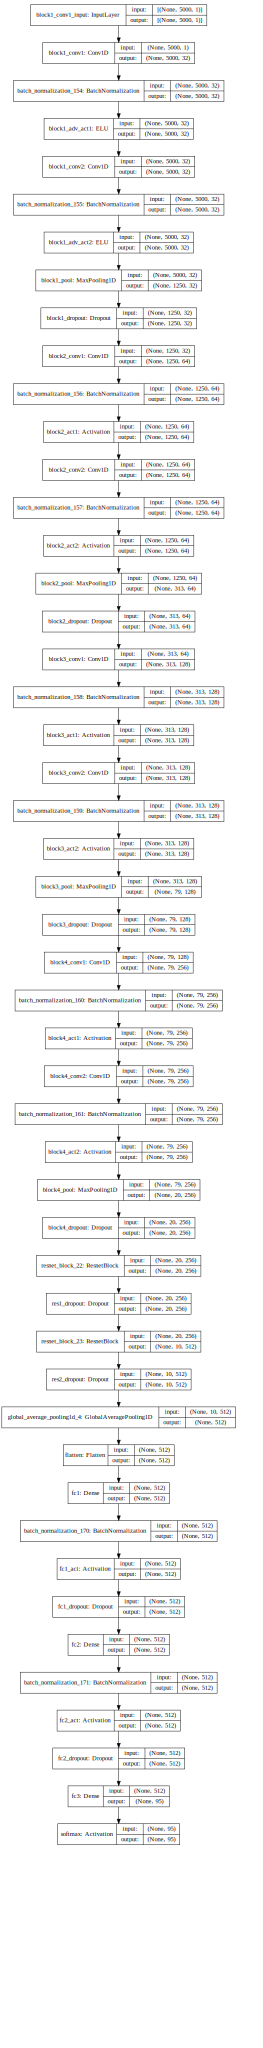

In [52]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))


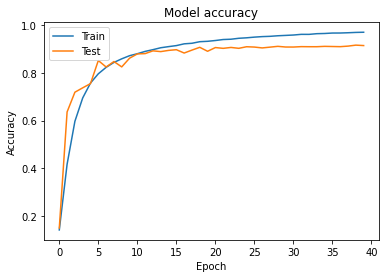

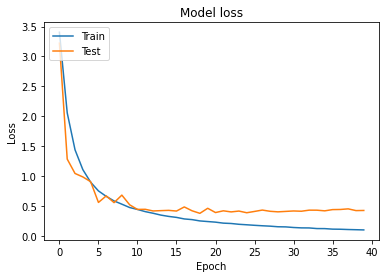

In [53]:
import matplotlib.pyplot as plt

# history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# 绘制训练 & 验证的准确率值
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()